# InvestigatorAI: Comprehensive RAGAS Evaluation Framework

## 🎯 Objective
This notebook implements comprehensive evaluation of our InvestigatorAI fraud investigation system using RAGAS with both RAG and Agent evaluation metrics:

### 📊 RAG Evaluation Metrics:
- **Faithfulness**: Response grounding in retrieved contexts
- **Answer Relevancy**: Response relevance to questions  
- **Context Precision**: Relevance of retrieved contexts
- **Context Recall**: Completeness of retrieved information

### 🤖 Agent Evaluation Metrics:
- **Tool Call Accuracy**: Correct tool usage and parameters
- **Agent Goal Accuracy**: Achievement of user's stated goals
- **Topic Adherence**: Staying on-topic for fraud investigation

### 📈 Integration:
- **LangSmith**: Capturing evaluation results and conversation traces
- **Real Data**: Using official FinCEN/FFIEC/FDIC regulatory documents
- **Multi-Agent System**: Evaluating our complete fraud investigation workflow

---

*Following AI Makerspace evaluation patterns with Task 5 certification requirements*


## 📦 Dependencies and Setup


In [1]:
# Core dependencies for RAGAS evaluation
import os
import sys
import asyncio
from getpass import getpass
from datetime import datetime
from typing import List, Dict, Any
import pandas as pd
import json

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset import TestsetGenerator
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

## 🔑 API Keys Configuration


In [2]:
# Configure API keys for evaluation
print("🔐 Setting up API keys for evaluation...")

# OpenAI API Key (required for LLM and embeddings)
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")
    
# LangSmith API Key (for evaluation tracking)
if not os.getenv("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass("Enter your LangSmith API key: ")

# External API keys (if not already set)
external_apis = [
    "TAVILY_SEARCH_API_KEY",
    "ALPHA_VANTAGE_API_KEY"
]

for api_key in external_apis:
    if not os.getenv(api_key):
        response = input(f"Enter {api_key} (or press Enter to skip): ")
        if response.strip():
            os.environ[api_key] = response.strip()

print("✅ API keys configured for evaluation!")


🔐 Setting up API keys for evaluation...
✅ API keys configured for evaluation!


## 🏗️ Load InvestigatorAI Components


In [24]:
# Import existing InvestigatorAI components
print("🔄 Loading InvestigatorAI components for evaluation...")

try:
    # Load core components
    from api.core.config import get_settings, initialize_llm_components
    from api.services.vector_store import VectorStoreService  
    from api.services.external_apis import ExternalAPIService
    from api.agents.multi_agent_system import FraudInvestigationSystem
    from api.models.schemas import InvestigationRequest
    
    print("✅ Core InvestigatorAI components loaded!")
    
    # Initialize settings and LLM components
    settings = get_settings()
    llm, embeddings = initialize_llm_components(settings)
    
    print("✅ Settings and LLM components initialized!")
    
    # Initialize services with required arguments
    vector_service = VectorStoreService(embeddings=embeddings, settings=settings)
    external_api_service = ExternalAPIService(settings=settings)
    
    # Initialize vector store from existing collection
    if vector_service.qdrant_client:
        try:
            from langchain_qdrant import QdrantVectorStore
            vector_service.vector_store = QdrantVectorStore(
                client=vector_service.qdrant_client,
                collection_name=settings.vector_collection_name,
                embedding=embeddings
            )
            vector_service.is_initialized = True
            print("✅ Vector store initialized from existing collection!")
        except Exception as e:
            print(f"⚠️  Could not initialize vector store: {e}")
    
    # Initialize multi-agent system
    fraud_system = FraudInvestigationSystem(
        llm=llm,
        external_api_service=external_api_service
    )
    
    fraud_system_agents = fraud_system.agents
    
    fraud_system_graph = fraud_system.investigation_graph
    
    
    print("✅ InvestigatorAI system initialized for evaluation!")
    
except ImportError as e:
    print(f"⚠️  Error loading InvestigatorAI components: {e}")
    print("💡 Make sure you're running from the project root directory")
except ValueError as e:
    print(f"⚠️  Configuration error: {e}")
    print("💡 Make sure your API keys are set in environment variables")
    
    
except Exception as e:
    print(f"⚠️  Unexpected error: {e}")
    print("🔄 Using fallback LLM configuration...")
    


🔄 Loading InvestigatorAI components for evaluation...
✅ Core InvestigatorAI components loaded!
✅ Settings and LLM components initialized!
✅ Connected to Qdrant at localhost:6333
📋 Available collections: 1
✅ Vector store initialized from existing collection!
✅ InvestigatorAI system initialized for evaluation!


## 📄 Load Regulatory Documents and Generate Synthetic Dataset


In [4]:
# Load regulatory PDFs and generate synthetic test dataset
print("📄 Loading regulatory documents for evaluation...")

# Load PDF documents from data directory
pdf_path = "data/pdf_downloads/"
loader = DirectoryLoader(pdf_path, glob="*.pdf", loader_cls=PyMuPDFLoader)
regulatory_docs = loader.load()

print(f"✅ Loaded {len(regulatory_docs)} regulatory document chunks")

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

print(f"✅ Generating {len(regulatory_docs)} synthetic test dataset...")

generator = TestsetGenerator(
    llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(
    regulatory_docs[:20], testset_size=10)
dataset.to_pandas()

📄 Loading regulatory documents for evaluation...
✅ Loaded 627 regulatory document chunks
✅ Generating 627 synthetic test dataset...


Applying HeadlinesExtractor:   0%|          | 0/18 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/34 [00:00<?, ?it/s]

Property 'summary' already exists in node '285c4d'. Skipping!
Property 'summary' already exists in node 'a3e74a'. Skipping!
Property 'summary' already exists in node 'b3b4cd'. Skipping!
Property 'summary' already exists in node '73347b'. Skipping!
Property 'summary' already exists in node '88b3e1'. Skipping!
Property 'summary' already exists in node '242cc5'. Skipping!
Property 'summary' already exists in node '90318a'. Skipping!
Property 'summary' already exists in node 'd9e72e'. Skipping!
Property 'summary' already exists in node '1fd1fb'. Skipping!
Property 'summary' already exists in node '2f7739'. Skipping!
Property 'summary' already exists in node 'b114cb'. Skipping!
Property 'summary' already exists in node '900284'. Skipping!
Property 'summary' already exists in node '5c9478'. Skipping!
Property 'summary' already exists in node 'a07442'. Skipping!
Property 'summary' already exists in node '5a7131'. Skipping!
Property 'summary' already exists in node '3fb170'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/4 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/42 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'b114cb'. Skipping!
Property 'summary_embedding' already exists in node '2f7739'. Skipping!
Property 'summary_embedding' already exists in node '88b3e1'. Skipping!
Property 'summary_embedding' already exists in node 'd9e72e'. Skipping!
Property 'summary_embedding' already exists in node '1fd1fb'. Skipping!
Property 'summary_embedding' already exists in node 'a3e74a'. Skipping!
Property 'summary_embedding' already exists in node '242cc5'. Skipping!
Property 'summary_embedding' already exists in node '5a7131'. Skipping!
Property 'summary_embedding' already exists in node '90318a'. Skipping!
Property 'summary_embedding' already exists in node '285c4d'. Skipping!
Property 'summary_embedding' already exists in node '900284'. Skipping!
Property 'summary_embedding' already exists in node 'b3b4cd'. Skipping!
Property 'summary_embedding' already exists in node '3fb170'. Skipping!
Property 'summary_embedding' already exists in node '73347b'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What role does the U.S. Department of the Trea...,[F I N C E N A D V I S O R Y 2 traffickers tar...,"According to the context, the U.S. Department ...",single_hop_specifc_query_synthesizer
1,What role does U.S. Customs and Border Protect...,"[Human Trafficking in Vulnerable Communities,”...",The U.S. Customs and Border Protection issues ...,single_hop_specifc_query_synthesizer
2,What are the requirements and limitations for ...,[Financial Crimes Enforcement Network Electron...,Filers can include a single Microsoft Excel co...,single_hop_specifc_query_synthesizer
3,"Wht r the formatin rulz for U.S., Canada, Mexi...",[<1-hop>\n\nFinancial Crimes Enforcement Netwo...,"For U.S., Canada, and Mexico addresses on FinC...",multi_hop_abstract_query_synthesizer
4,According to FinCEN SAR electronic filing requ...,[<1-hop>\n\nFinancial Crimes Enforcement Netwo...,FinCEN SAR electronic filing requirements allo...,multi_hop_abstract_query_synthesizer
5,Whaat are the formattin ruls for adresses in t...,[<1-hop>\n\nFinancial Crimes Enforcement Netwo...,"For adresses in the U.S., Canada, or Mexico on...",multi_hop_abstract_query_synthesizer
6,According to FinCEN advisories and related U.S...,[<1-hop>\n\nF I N C E N A D V I S O R Y 2 traf...,Forced labor and child labor in supply chains ...,multi_hop_abstract_query_synthesizer
7,"finCEN SAR need keep what doc and how long, an...",[<1-hop>\n\nF I N C E N A D V I S O R Y 2 traf...,FinCEN SAR filers must keep copies of the SAR ...,multi_hop_specific_query_synthesizer
8,How does FinCEN guidance on human trafficking ...,[<1-hop>\n\nF I N C E N A D V I S O R Y 2 traf...,FinCEN guidance highlights the importance of i...,multi_hop_specific_query_synthesizer
9,How do the U.S. Department of Labor and the U....,[<1-hop>\n\nHuman Trafficking in Vulnerable Co...,The U.S. Department of Labor contributes to ef...,multi_hop_specific_query_synthesizer


## 🤖 Generate Responses with InvestigatorAI Multi-Agent System

Now we'll use your synthetic dataset to generate responses with the InvestigatorAI system and then evaluate them with RAGAS.


In [5]:
# Generate responses using InvestigatorAI for each question in the synthetic dataset
print("🤖 Generating responses using InvestigatorAI multi-agent system...")

# Extract questions from the synthetic dataset
questions = dataset.to_pandas()['user_input'].tolist()
reference_contexts = dataset.to_pandas()['reference_contexts'].tolist()
ground_truths = dataset.to_pandas()['reference'].tolist()

print(f"📝 Processing {len(questions)} questions from synthetic dataset...")

# Store evaluation data
evaluation_responses = []
contexts_retrieved = []
prompts = []

# Process each question (limiting to first 5 for initial evaluation)
for i, question in enumerate(questions):
    print(f"\n🔄 Processing question {i+1}/{len(questions)}: {question}...")
    
    try:
        # Search vector store for relevant contexts (direct RAG approach)
        search_results = vector_service.search(question, k=3)
        retrieved_contexts = [result.content for result in search_results]
        
        # Generate response using LLM with retrieved contexts
        context_text = "\n\n".join(retrieved_contexts)
        
        prompt = f"""Based on the following regulatory documents, answer this question:

                Question: {question}

                Relevant Documents:
                {context_text}

                Please provide a comprehensive answer based on the regulatory guidance above."""

        response = llm.invoke(prompt)
        answer = response.content if hasattr(response, 'content') else str(response)
        
        evaluation_responses.append(answer)
        contexts_retrieved.append(retrieved_contexts)
        prompts.append(prompt)
        
        
        print(f"✅ Generated response ({len(answer)} chars)")
        
    except Exception as e:
        print(f"⚠️  Error processing question {i+1}: {e}")
        evaluation_responses.append(f"Error: {str(e)}")
        contexts_retrieved.append([])

print(f"\n✅ Generated {len(evaluation_responses)} responses for RAGAS evaluation!")



🤖 Generating responses using InvestigatorAI multi-agent system...
📝 Processing 11 questions from synthetic dataset...

🔄 Processing question 1/11: What role does the U.S. Department of the Treasury play in combatting human trafficking according to recent advisories?...
✅ Generated response (587 chars)

🔄 Processing question 2/11: What role does U.S. Customs and Border Protection play regarding goods produced by forced or child labor?...
✅ Generated response (643 chars)

🔄 Processing question 3/11: What are the requirements and limitations for including a CSV file as supporting documentation when filing a FinCEN Suspicious Activity Report (SAR), and how should its contents be described and retained according to regulatory guidelines?...
✅ Generated response (983 chars)

🔄 Processing question 4/11: Wht r the formatin rulz for U.S., Canada, Mexico, an foren adreses on FinCEN SARs, includin how ZIP an postal codes shud be enterd?...
✅ Generated response (737 chars)

🔄 Processing question 5

In [6]:
# Add the generated data to the dataset
print("📊 Adding evaluation results to dataset...")

# Convert dataset to pandas for easier manipulation
df = dataset.to_pandas()

# Add new columns for all samples
df_augmented = df.copy()

# Add the generated data
df_augmented['response'] = evaluation_responses
df_augmented['retrieved_contexts'] = contexts_retrieved
df_augmented['full_prompt'] = prompts

print(f"✅ Dataset augmented with evaluation data!")
print(f"📋 Dataset now contains {len(df_augmented)} evaluated samples with:")
print(f"   - Original questions: user_input")
print(f"   - Generated answers: response")
print(f"   - Retrieved contexts: retrieved_contexts")
print(f"   - Full prompts: full_prompt")
print(f"   - Ground truth: reference")
print(f"   - Reference contexts: reference_contexts")

# Display a sample
print(f"\n📝 Sample augmented data:")
print(f"Question: {df_augmented.iloc[0]['user_input'][:100]}...")
print(f"Generated Answer: {df_augmented.iloc[0]['response'][:100]}...")
print(
    f"Retrieved Contexts: {len(df_augmented.iloc[0]['retrieved_contexts'])} contexts")
print(f"Ground Truth: {df_augmented.iloc[0]['reference'][:100]}...")

df_augmented.head()

📊 Adding evaluation results to dataset...
✅ Dataset augmented with evaluation data!
📋 Dataset now contains 11 evaluated samples with:
   - Original questions: user_input
   - Generated answers: response
   - Retrieved contexts: retrieved_contexts
   - Full prompts: full_prompt
   - Ground truth: reference
   - Reference contexts: reference_contexts

📝 Sample augmented data:
Question: What role does the U.S. Department of the Treasury play in combatting human trafficking according to...
Generated Answer: The documents do not provide specific details on the role of the U.S. Department of the Treasury in ...
Retrieved Contexts: 3 contexts
Ground Truth: According to the context, the U.S. Department of the Treasury is involved in combatting human traffi...


,user_input,reference_contexts,reference,synthesizer_name,response,retrieved_contexts,full_prompt
0,What role does the U.S. Department of the Trea...,[F I N C E N A D V I S O R Y 2 traffickers tar...,"According to the context, the U.S. Department ...",single_hop_specifc_query_synthesizer,The documents do not provide specific details ...,[in response to inquiry. 28. Additional resour...,"Based on the following regulatory documents, a..."
1,What role does U.S. Customs and Border Protect...,"[Human Trafficking in Vulnerable Communities,”...",The U.S. Customs and Border Protection issues ...,single_hop_specifc_query_synthesizer,U.S. Customs and Border Protection (CBP) plays...,[imported into the United States. The U.S. Cus...,"Based on the following regulatory documents, a..."
2,What are the requirements and limitations for ...,[Financial Crimes Enforcement Network Electron...,Filers can include a single Microsoft Excel co...,single_hop_specifc_query_synthesizer,When filing a FinCEN Suspicious Activity Repor...,[the FinCEN SAR and their own supporting docum...,"Based on the following regulatory documents, a..."
3,"Wht r the formatin rulz for U.S., Canada, Mexi...",[<1-hop>\n\nFinancial Crimes Enforcement Netwo...,"For U.S., Canada, and Mexico addresses on FinC...",multi_hop_abstract_query_synthesizer,"The formation rules for addresses in the U.S.,...","[as copies of instruments; receipts; sale, tra...","Based on the following regulatory documents, a..."
4,According to FinCEN SAR electronic filing requ...,[<1-hop>\n\nFinancial Crimes Enforcement Netwo...,FinCEN SAR electronic filing requirements allo...,multi_hop_abstract_query_synthesizer,According to the FinCEN SAR electronic filing ...,[Add Attachment: Filers can include with a Fin...,"Based on the following regulatory documents, a..."


## 📊 Prepare RAGAS Evaluation Dataset

Now we'll use the augmented dataset to prepare the exact format needed for RAGAS evaluation.


In [ ]:
from ragas import evaluate, RunConfig
from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    ContextPrecision,
    ContextRecall
)
from ragas import EvaluationDataset
from ragas.llms import LangchainLLMWrapper

evaluation_dataset = EvaluationDataset.from_pandas(df_augmented)
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-o4-mini"))

run_config = RunConfig(timeout=360)

## 📊 RAG Evaluation with RAGAS Core Metrics

Now we'll evaluate the RAG performance using the four core RAGAS metrics: faithfulness, answer relevancy, context precision, and context recall.


In [8]:
results = evaluate(
    evaluation_dataset,
    metrics=[Faithfulness(), AnswerRelevancy(),
             ContextPrecision(), ContextRecall()],
    llm=evaluator_llm,
    run_config=run_config
)

results

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

{'faithfulness': 0.7399, 'answer_relevancy': 0.6722, 'context_precision': 1.0000, 'context_recall': 0.5461}

In [9]:
results.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,faithfulness,answer_relevancy,context_precision,context_recall
0,What role does the U.S. Department of the Trea...,[in response to inquiry. 28. Additional resour...,[F I N C E N A D V I S O R Y 2 traffickers tar...,The documents do not provide specific details ...,"According to the context, the U.S. Department ...",0.300000,0.000000,1.0,0.500000
1,What role does U.S. Customs and Border Protect...,[imported into the United States. The U.S. Cus...,"[Human Trafficking in Vulnerable Communities,”...",U.S. Customs and Border Protection (CBP) plays...,The U.S. Customs and Border Protection issues ...,0.500000,0.990464,1.0,1.000000
2,What are the requirements and limitations for ...,[the FinCEN SAR and their own supporting docum...,[Financial Crimes Enforcement Network Electron...,When filing a FinCEN Suspicious Activity Repor...,Filers can include a single Microsoft Excel co...,1.000000,0.927961,1.0,1.000000
3,"Wht r the formatin rulz for U.S., Canada, Mexi...","[as copies of instruments; receipts; sale, tra...",[<1-hop>\n\nFinancial Crimes Enforcement Netwo...,"The formation rules for addresses in the U.S.,...","For U.S., Canada, and Mexico addresses on FinC...",1.000000,0.888324,1.0,0.555556
4,According to FinCEN SAR electronic filing requ...,[Add Attachment: Filers can include with a Fin...,[<1-hop>\n\nFinancial Crimes Enforcement Netwo...,According to the FinCEN SAR electronic filing ...,FinCEN SAR electronic filing requirements allo...,0.818182,0.904844,1.0,0.142857
5,Whaat are the formattin ruls for adresses in t...,"[as copies of instruments; receipts; sale, tra...",[<1-hop>\n\nFinancial Crimes Enforcement Netwo...,"When filling out a FinCEN SAR, the formatting ...","For adresses in the U.S., Canada, or Mexico on...",1.000000,0.911317,1.0,0.375000
6,According to FinCEN advisories and related U.S...,[imported into the United States. The U.S. Cus...,[<1-hop>\n\nF I N C E N A D V I S O R Y 2 traf...,Forced labor and child labor in supply chains ...,Forced labor and child labor in supply chains ...,0.722222,0.931847,1.0,0.600000
7,"finCEN SAR need keep what doc and how long, an...",[the FinCEN SAR and their own supporting docum...,[<1-hop>\n\nF I N C E N A D V I S O R Y 2 traf...,The FinCEN SAR (Suspicious Activity Report) an...,FinCEN SAR filers must keep copies of the SAR ...,0.909091,0.873791,1.0,0.333333
8,How does FinCEN guidance on human trafficking ...,[not be reported as the subject of a SAR. Rath...,[<1-hop>\n\nF I N C E N A D V I S O R Y 2 traf...,FinCEN guidance on human trafficking relates t...,FinCEN guidance highlights the importance of i...,0.818182,0.965494,1.0,0.666667
9,How do the U.S. Department of Labor and the U....,[imported into the United States. The U.S. Cus...,[<1-hop>\n\nHuman Trafficking in Vulnerable Co...,The U.S. Department of Labor contributes to ef...,The U.S. Department of Labor contributes to ef...,0.500000,0.000000,1.0,0.500000


## 🤖 Agent Evaluation with RAGAS Agent Metrics

Finally, let's evaluate the agent performance using Tool Call Accuracy, Agent Goal Accuracy, and Topic Adherence.


## 🤖 Agent Evaluation with RAGAS Agent Metrics

Now let's evaluate the agent performance using Tool Call Accuracy, Agent Goal Accuracy, and Topic Adherence following the AI Makerspace template.


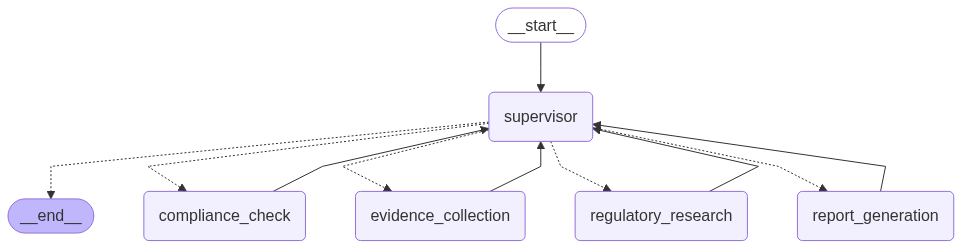

In [10]:
fraud_system_graph

In [53]:
import time
# 🌐 Using the API endpoint - proper tool call handling!
print("🌐 Making request to InvestigatorAI API endpoint...")

import requests
import json

# API endpoint URL (assuming API is running)
API_BASE_URL = "http://localhost:8000"

# Create investigation request matching the API schema
investigation_request = {
    "amount": 75000.0,
    "currency": "USD", 
    "description": "Large international wire transfer to high-risk jurisdiction",
    "customer_name": "Global Trading LLC",
    "account_type": "Business",
    "risk_rating": "High",
    "country_to": "Iran"
}

print(f"📤 Sending investigation request to {API_BASE_URL}/investigate")
print(f"📋 Request data: {json.dumps(investigation_request, indent=2)}")

try:
    # Make API call with increased timeout for comprehensive investigation
    print("⏱️  Starting investigation (may take 3-5 minutes for comprehensive analysis)...")
    response = requests.post(
        f"{API_BASE_URL}/investigate",
        json=investigation_request,
        timeout=300,  # Increased to 5 minutes for full multi-agent investigation
        headers={"Content-Type": "application/json"}
    )
    
    if response.status_code == 200:
        api_result = response.json()
        print("✅ Investigation completed via API!")
        print(f"📋 Status: {api_result.get('status')}")
        print(f"🎯 Final Decision: {api_result.get('final_decision')}")
        print(f"📊 Agents Completed: {api_result.get('agents_completed')}")
        print(f"💬 Total Messages: {api_result.get('total_messages')}")
        
        # Extract full results with complete message history
        full_results = api_result.get("full_results", {})
        messages = full_results.get("messages", [])
        
        print(f"🛠️  Found {len(messages)} messages in full results")
        
        # Check for tool calls in the message history  
        tool_call_count = 0
        ai_message_count = 0
        tool_message_count = 0
        human_message_count = 0
        
        for i, msg in enumerate(messages):
            if isinstance(msg, dict):
                msg_type = msg.get("type", "unknown")
                print(f"  Message {i}: {msg_type}")
                
                if msg.get("tool_calls"):
                    tool_call_count += len(msg["tool_calls"])
                    print(f"    → Has {len(msg['tool_calls'])} tool calls")
                    
                if msg_type == "ai":
                    ai_message_count += 1
                elif msg_type == "tool":
                    tool_message_count += 1
                elif msg_type == "human":
                    human_message_count += 1
            time.sleep(5)
        
        print(f"\n📊 MESSAGE SUMMARY:")
        print(f"🤖 AIMessage objects: {ai_message_count}")
        print(f"👤 HumanMessage objects: {human_message_count}")
        print(f"🔧 ToolMessage objects: {tool_message_count}") 
        print(f"🛠️  Total tool calls: {tool_call_count}")
        
        # Store results for RAGAS evaluation
        agent_results = [{
            "messages": messages
        }]
        
        print(f"✅ Generated {len(agent_results)} agent investigation for evaluation!")
        
    else:
        print(f"❌ API request failed: {response.status_code}")
        print(f"Error: {response.text}")
        agent_results = []
        
except requests.exceptions.ConnectionError:
    print("❌ Could not connect to API server!")
    print("💡 Make sure the API server is running:")
    print("   uvicorn api.main:app --host 0.0.0.0 --port 8000")
    agent_results = []
    
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    agent_results = []



🌐 Making request to InvestigatorAI API endpoint...
📤 Sending investigation request to http://localhost:8000/investigate
📋 Request data: {
  "amount": 75000.0,
  "currency": "USD",
  "description": "Large international wire transfer to high-risk jurisdiction",
  "customer_name": "Global Trading LLC",
  "account_type": "Business",
  "risk_rating": "High",
  "country_to": "Iran"
}
⏱️  Starting investigation (may take 3-5 minutes for comprehensive analysis)...
✅ Investigation completed via API!
📋 Status: completed
🎯 Final Decision: **FRAUD INVESTIGATION COMPLETE**

**KEY FINDINGS:**

**System**: Investigate this transaction:
            
            Transaction Details:
            - Amount: $75,000.0 USD
            - Description: Large international wire transfer to high-risk jurisdiction
            - Customer: Global Trading LLC
            - Account Type: Business
            - Customer Risk Rating: High
            - Destination Country: Iran
            - Timestamp: 2025-08-02T16:06

In [54]:
agent_results

[{'messages': [{'content': 'Investigate this transaction:\n            \n            Transaction Details:\n            - Amount: $75,000.0 USD\n            - Description: Large international wire transfer to high-risk jurisdiction\n            - Customer: Global Trading LLC\n            - Account Type: Business\n            - Customer Risk Rating: High\n            - Destination Country: Iran\n            - Timestamp: 2025-08-02T16:06:29.480531\n            \n            Please conduct a comprehensive fraud investigation including:\n            1. Regulatory compliance assessment\n            2. Risk score calculation and evidence collection\n            3. Filing requirement determination\n            4. Investigation report generation\n            ',
    'type': 'HumanMessage',
    'name': 'system',
    'timestamp': '2025-08-02T16:07:31.514290'},
   {'content': 'Routing investigation to regulatory_research agent for specialized analysis.',
    'type': 'HumanMessage',
    'name': 'sup

### 🔍 Debug Agent Results Structure


In [55]:
# Debug: Check the actual message structure and tool calls


# Show the actual raw messages
agent_results[0]['messages']

[{'content': 'Investigate this transaction:\n            \n            Transaction Details:\n            - Amount: $75,000.0 USD\n            - Description: Large international wire transfer to high-risk jurisdiction\n            - Customer: Global Trading LLC\n            - Account Type: Business\n            - Customer Risk Rating: High\n            - Destination Country: Iran\n            - Timestamp: 2025-08-02T16:06:29.480531\n            \n            Please conduct a comprehensive fraud investigation including:\n            1. Regulatory compliance assessment\n            2. Risk score calculation and evidence collection\n            3. Filing requirement determination\n            4. Investigation report generation\n            ',
  'type': 'HumanMessage',
  'name': 'system',
  'timestamp': '2025-08-02T16:07:31.514290'},
 {'content': 'Routing investigation to regulatory_research agent for specialized analysis.',
  'type': 'HumanMessage',
  'name': 'supervisor',
  'timestamp': '

### Tool Call Accuracy


In [ ]:
# Tool Call Accuracy evaluation - SIMPLIFIED!
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
import ragas.messages as r
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

def to_lc_message(d):
    """Convert dictionary message to LangChain message - SIMPLE VERSION"""
    from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
    
    role = d.get("type", "")
    content = d.get("content", "")
    name = d.get("name")

    if role == "AIMessage":
        # Extract tool calls from the dictionary (API now provides proper format)
        tool_calls = d.get("tool_calls")
        return AIMessage(content=content, tool_calls=tool_calls, name=name)

    elif role == "ToolMessage":
        return ToolMessage(
            content=content,
            tool_call_id=d.get("tool_call_id"),
            name=name,
        )

    elif role == "SystemMessage":
        return SystemMessage(content=content, name=name)

    # Default to HumanMessage
    return HumanMessage(content=content, name=name)

if agent_results and agent_results[0]:
    print("📊 Evaluating Tool Call Accuracy...")
    
    try:
        # Get dictionary messages from API (now properly formatted with tool calls!)
        dict_messages = agent_results[0]["messages"]
        print(f"🔍 Got {len(dict_messages)} dictionary messages from API")
        
        # Simple conversion - no complex repair needed!
        langchain_messages = [to_lc_message(msg) for msg in dict_messages]
        print(f"✅ Converted to {len(langchain_messages)} LangChain message objects")
        
        # Count tool calls for verification
        ai_with_tools = sum(1 for msg in langchain_messages if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls)
        tool_messages = sum(1 for msg in langchain_messages if isinstance(msg, ToolMessage))
        print(f"🛠️  Found {ai_with_tools} AIMessages with tool calls and {tool_messages} ToolMessages")
        
        # Create MultiTurnSample directly
        sample = MultiTurnSample(
            user_input=langchain_messages,
            reference_tool_calls=[
                r.ToolCall(name="search_regulatory_documents", args={"query": "Iran sanctions compliance"}),
                r.ToolCall(name="calculate_transaction_risk", args={"amount": 75000.0, "country_to": "Iran"}),
                r.ToolCall(name="check_compliance_requirements", args={"amount": 75000.0, "risk_score": 1.0})
            ],
        )
        print(f"✅ MultiTurnSample created successfully")
        
        tool_accuracy_scorer = ToolCallAccuracy()
        tool_accuracy_scorer.llm = ChatOpenAI(model="gpt-4o-mini")
        tool_accuracy_score = await tool_accuracy_scorer.multi_turn_ascore(sample)
        
        print(f"✅ Tool Call Accuracy: {tool_accuracy_score}")
        
    except Exception as e:
        print(f"❌ Error in Tool Call Accuracy evaluation: {e}")
        print(f"🔍 Error details: {str(e)}")
else:
    print("⚠️  No agent result available for Tool Call Accuracy evaluation")


📊 Evaluating Tool Call Accuracy...
🔍 Got 24 dictionary messages from API
✅ Converted to 24 LangChain message objects

🔧 Applying RAGAS repair to fix message sequence...
🧹 Filtering status line: Routing investigation to regulatory_research agent...
🧹 Filtering status line: **REGULATORY ANALYSIS REPORT**

**Jurisdiction Ass...
🧹 Filtering status line: Routing investigation to evidence_collection agent...
🧹 Filtering status line: **EVIDENCE COLLECTION REPORT**

**Risk Score Analy...
🧹 Filtering status line: Routing investigation to compliance_check agent fo...
🧹 Filtering status line: **COMPLIANCE ASSESSMENT REPORT**

**Filing Obligat...
🧹 Filtering status line: Routing investigation to report_generation agent f...
🧹 Filtering status line: **EXECUTIVE SUMMARY**
- **Transaction Overview:** ...
🧹 Filtering status line: Investigation completed. All specialist agents hav...
🧹 Filtered 24 → 15 messages (removed status lines)
✅ Final normalization: 15 → 15 messages for RAGAS
✅ Repaired sequence

### Agent Goal Accuracy


In [ ]:
# Agent Goal Accuracy evaluation - SIMPLIFIED!
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper

if agent_results and agent_results[0]:
    print("📊 Evaluating Agent Goal Accuracy...")
    
    try:
        # Get dictionary messages and convert to LangChain objects - SIMPLE!
        dict_messages = agent_results[0]["messages"]
        langchain_messages = [to_lc_message(msg) for msg in dict_messages]
        print(f"✅ Converted {len(langchain_messages)} messages for Agent Goal Accuracy evaluation")
        
        sample = MultiTurnSample(
            user_input=langchain_messages,
            reference="Complete fraud investigation analysis including risk assessment (1.0 risk score), compliance requirements (SAR filing, OFAC screening), and regulatory documentation for large international wire transfer to sanctioned jurisdiction (Iran). Investigation should identify sanctions violations, money laundering risks, and provide comprehensive compliance recommendations.",
        )
        
        scorer = AgentGoalAccuracyWithReference()
        evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
        scorer.llm = evaluator_llm
        goal_accuracy_score = await scorer.multi_turn_ascore(sample)
        
        print(f"✅ Agent Goal Accuracy: {goal_accuracy_score}")
        
    except Exception as e:
        print(f"❌ Error in Agent Goal Accuracy evaluation: {e}")
        print(f"🔍 Error details: {str(e)}")
else:
    print("⚠️  No agent result available for Agent Goal Accuracy evaluation")


📊 Evaluating Agent Goal Accuracy...
🔧 Creating AIMessage → ToolMessage pair for tool 'search_regulatory_documents' (id: call_search_regulatory_documents_0)
🔧 Creating AIMessage → ToolMessage pair for tool 'search_web_intelligence' (id: call_search_web_intelligence_2)
🔧 Creating AIMessage → ToolMessage pair for tool 'calculate_transaction_risk' (id: call_calculate_transaction_risk_0)
🔧 Creating AIMessage → ToolMessage pair for tool 'get_exchange_rate_data' (id: call_get_exchange_rate_data_2)
🔧 Creating AIMessage → ToolMessage pair for tool 'search_web_intelligence' (id: call_search_web_intelligence_4)
🔧 Creating AIMessage → ToolMessage pair for tool 'check_compliance_requirements' (id: call_check_compliance_requirements_0)
🔧 Creating AIMessage → ToolMessage pair for tool 'search_regulatory_documents' (id: call_search_regulatory_documents_2)
✅ Normalized 24 → 24 messages for RAGAS
✅ Converted and repaired 24 messages for Agent Goal Accuracy evaluation
❌ Error in Agent Goal Accuracy evalu

In [ ]:
# Topic Adherence evaluation - SIMPLIFIED!
from ragas.metrics import TopicAdherenceScore

if agent_results and agent_results[0]:
    print("📊 Evaluating Topic Adherence...")
    
    try:
        # Get dictionary messages and convert to LangChain objects - SIMPLE!
        dict_messages = agent_results[0]["messages"]
        langchain_messages = [to_lc_message(msg) for msg in dict_messages]
        print(f"✅ Converted {len(langchain_messages)} messages for Topic Adherence evaluation")
        
        sample = MultiTurnSample(
            user_input=langchain_messages,
            reference_topics=["fraud investigation", "regulatory compliance", "AML", "BSA", "SAR reporting", "CTR reporting", "risk assessment", "shell companies", "money laundering", "financial crime", "OFAC sanctions", "Iran sanctions", "wire transfers", "enhanced due diligence", "suspicious activity reporting"]
        )
        
        evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
        scorer = TopicAdherenceScore(llm=evaluator_llm, mode="precision")
        topic_adherence_score = await scorer.multi_turn_ascore(sample)
        
        print(f"✅ Topic Adherence: {topic_adherence_score}")
        
    except Exception as e:
        print(f"❌ Error in Topic Adherence evaluation: {e}")
        print(f"🔍 Error details: {str(e)}")
else:
    print("⚠️  No agent result available for Topic Adherence evaluation")

print("\n🎉 Agent Evaluation Complete!")
print("✅ Evaluated InvestigatorAI agent with three RAGAS agent metrics")
print("📊 Tool Call Accuracy, Agent Goal Accuracy, and Topic Adherence assessed")


⚠️  No agent result available for Topic Adherence evaluation

🎉 Agent Evaluation Complete!
✅ Evaluated InvestigatorAI agent with three RAGAS agent metrics
📊 Tool Call Accuracy, Agent Goal Accuracy, and Topic Adherence assessed
